In [1]:
import requests
import sys
import pandas as pd
import numpy as np
from scipy import sparse
from io import StringIO
import networkscience as ns
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
datasets = ['Erasmus14.csv', 'Erasmus15.csv', 'Erasmus16.csv', 'Erasmus17.csv', 'Erasmus18.csv', 'Erasmus19.csv']
local_dir = r"C:\Users\Utente\Downloads\data\\"

mobility_df = pd.read_csv(local_dir + datasets[0], sep=';',low_memory=False, header=0)
for i in range(1, len(datasets)):
    mobility_df = pd.concat([mobility_df, pd.read_csv(local_dir + datasets[i], sep=';',low_memory=False, header=0)], axis=0)

In [3]:
display(mobility_df)

,Project Reference,Academic Year,Mobility Start Month,Mobility End Month,Mobility Duration,Activity (mob),Field of Education,Participant Nationality,Education Level,Participant Gender,...,Participant Age,Sending Country Code,Sending City,Sending Organization,Sending Organisation Erasmus Code,Receiving Country Code,Receiving City,Receiving Organization,Receiving Organisation Erasmus Code,Participants
0,2014-1-AT01-KA101-000059,2014-2015,2014-07,2014-07,12.0,Staff training abroad,Language acquisition,AT,??? - ? Unknown ?,Female,...,42,AT,Wels,BRG Wels Wallererstraße,-,ES,Malaga,Escuela de Idiomas Nerja,-,1
1,2014-1-AT01-KA101-000059,2014-2015,2014-07,2014-08,7.0,Staff training abroad,Language acquisition,AT,??? - ? Unknown ?,Female,...,25,AT,Wels,BRG Wels Wallererstraße,-,UK,Canterbury,Pilgrims LTD,-,1
2,2014-1-AT01-KA101-000059,2014-2015,2014-07,2014-08,12.0,Staff training abroad,Language acquisition,AT,??? - ? Unknown ?,Female,...,51,AT,Wels,BRG Wels Wallererstraße,-,UK,London,St. Giles International,-,1
3,2014-1-AT01-KA101-000059,2014-2015,2014-08,2014-08,12.0,Staff training abroad,Language acquisition,CZ,??? - ? Unknown ?,Female,...,34,AT,Wels,BRG Wels Wallererstraße,-,UK,London,EF Language Center,-,1
4,2014-1-AT01-KA101-000060,2014-2015,2014-07,2014-07,12.0,Staff training abroad,Teacher training with subject specialization,AT,??? - ? Unknown ?,Female,...,53,AT,Schwarzach,Volksschule Schwarzach,-,IE,Dublin,Centre of English Studies,-,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
736429,2019-2-UK01-KA105-062363,2019-2020,2019-09,2019-10,7.0,Mobility of youth workers - Programme Countries,? Unknown ?,TR,??? - ? Unknown ?,Female,...,24,UK,London,YOUTH INNOVATION LTD,-,UK,London,YOUTH INNOVATION LTD,-,1
736430,2019-2-UK01-KA105-062363,2019-2020,2019-09,2019-10,7.0,Mobility of youth workers - Programme Countries,? Unknown ?,UK,??? - ? Unknown ?,Female,...,32,UK,London,YOUTH INNOVATION LTD,-,UK,London,YOUTH INNOVATION LTD,-,1
736431,2019-2-UK01-KA105-062363,2019-2020,2019-09,2019-10,7.0,Mobility of youth workers - Programme Countries,? Unknown ?,UK,??? - ? Unknown ?,Female,...,37,UK,London,YOUTH INNOVATION LTD,-,UK,London,YOUTH INNOVATION LTD,-,1
736432,2019-2-UK01-KA105-062363,2019-2020,2019-09,2019-10,7.0,Mobility of youth workers - Programme Countries,? Unknown ?,UK,??? - ? Unknown ?,Male,...,41,UK,London,YOUTH INNOVATION LTD,-,UK,London,YOUTH INNOVATION LTD,-,1


In [4]:
def filter_data(df):
    df= df[df['Participant Profile']=='Learner']
    df= df[df['Activity (mob)'].str.contains('Student')]
    df = df[~df['Activity (mob)'].str.contains('traineeship')]
    df = df.loc[:, ['Sending Organization', 'Receiving Organization', 'Participants', 'Field of Education']]
    return df

mobility_df = filter_data(mobility_df)

for index in range(len(mobility_df['Sending Organization'])):
    s_uni = mobility_df.iat[index,0]
    r_uni = mobility_df.iat[index,1]
    if s_uni != s_uni.upper():
        mobility_df.iat[index,0] = s_uni.upper()
    if r_uni != r_uni.upper():
        mobility_df.iat[index,1] = r_uni.upper()
        
display(mobility_df)

,Sending Organization,Receiving Organization,Participants,Field of Education
1701,PRIVATE PÄDAGOGISCHE HOCHSCHULE - HOCHSCHULSTI...,ABO AKADEMI,1,Education
1702,PRIVATE PÄDAGOGISCHE HOCHSCHULE - HOCHSCHULSTI...,MALMOE HOEGSKOLA (MALMOE UNIVERSITY),2,Education
1733,IMC FACHHOCHSCHULE KREMS GMBH,HASKOLINN A BIFROST,1,Business and administration
1734,IMC FACHHOCHSCHULE KREMS GMBH,LAUREA-AMMATTIKORKEAKOULU OY,1,"Travel, tourism and leisure"
1735,IMC FACHHOCHSCHULE KREMS GMBH,METROPOLIA AMMATTIKORKEAKOULU OY,1,"Business, administration and law"
...,...,...,...,...
716937,UNIVERSITY COLLEGE LONDON,FEDERAL STATE AUTONOMOUS EDUCATIONAL INSTITUTI...,1,Political sciences and civics
716938,HEBRON UNIVERSITY,UNIVERSITY OF BRADFORD,1,Pharmacy
716939,HEBRON UNIVERSITY,UNIVERSITY OF BRADFORD,1,Pharmacy
716940,HEBRON UNIVERSITY,UNIVERSITY OF BRADFORD,3,Pharmacy


In [5]:
print('Number of Receiving Universities: ',(mobility_df['Receiving Organization'].nunique()))
print('Number of Sending Universities: ',(mobility_df['Sending Organization'].nunique()))

Number of Receiving Universities:  5220
Number of Sending Universities:  6253


In [6]:
df_w_fields = mobility_df.copy()

In [25]:
node_df = mobility_df.iloc[:, [0,4]].groupby(['Sending Organization', 'Sending Country Code']).sum()
node_df.to_csv('nodes_universities.csv')
mob_df = mobility_df.rename({'Sending Organization': 'source','Receiving Organization': 'target', 'Participants':'weight'},axis=1)
edges_df = mob_df.iloc[:,[0,1,2] ].groupby(['source', 'target']).sum()
edges_df
edges_df.to_csv('edges_universities.csv')
node_df

,
Sending Organization,Sending Country Code
"""ADA"" UNIVERSITY",AZ
"""FINANCIAL ACADEMY""",KZ
"""KATHOLISCHE STIFTUNGSHOCHSCHULE MÜNCHEN"" HOCHSCHULE FÜR ANGEWANDTE WISSENSCHAFTEN DER KIRCHLICHEN STIFTUNG DES ÖFFENTLICHEN RECHTS ""KATHOLISCHE BILDUNGSSTÄTTEN FÜR SOZIALBERUFE IN BAYERN""",DE
"""KROK"" UNIVERSITY",UA
''FRENCH UNIVERSITY IN ARMENIA'' FOUNDATION,AM
...,...
ÜSKÜDAR UNIVERSITY,TR
РОССИЙСКАЯ АКАДЕМИЯ НАРОДНОГО ХОЗЯЙСТВА И ГОСУДАРСТВЕННОЙ СЛУЖБЫ ПРИ ПРЕЗИДЕНТЕ РОССИЙСКОЙ ФЕДЕРАЦИИ,RU
РОССИЙСКИЙ ГОСУДАРСТВЕННЫЙ АГРАРНЫЙ УНИВЕРСИТЕТ - МСХА ИМЕНИ К.А. ТИМИРЯЗЕВА,RU


In [7]:
nodes = np.array(list(set.union(set(mobility_df.loc[:, mobility_df.columns[0]]), set(mobility_df.loc[:, mobility_df.columns[1]]))))
node_position = {}
for i, name in enumerate(nodes):
    node_position[name] = i
nodes_df = pd.DataFrame({'Nodes': nodes})
mobility_df['SendId'] = (np.array(list(map(lambda x: node_position[x], mobility_df['Sending Organization']))))
mobility_df['RecId']= (np.array(list(map(lambda x: node_position[x], mobility_df['Receiving Organization']))))
# Adjacency matrix
adj_matrix_crs = sparse.csr_matrix((nodes.size, nodes.size),dtype=int)
adj_matrix_csc = sparse.csc_matrix((nodes.size, nodes.size),dtype=int)

In [8]:
mobility_serie = mobility_df.groupby(['SendId', 'RecId']).sum()
row = np.array(mobility_serie.index.get_level_values(1).tolist())
col = np.array(mobility_serie.index.get_level_values(0).tolist())
val = mobility_serie.values
adj_matrix_crs = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))

# cercasi 70 Gb di ram, no perditempo
# ns.visualize_adj(adj_matrix_crs)

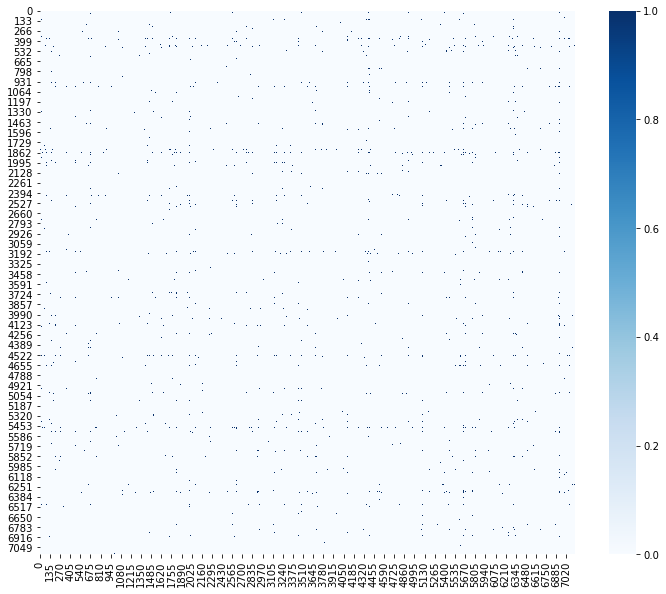

In [9]:
fig, ax = plt.subplots(1,1,figsize=(12,10))
a_adj = adj_matrix_crs.toarray()
a_adj[a_adj>1] = 1
sns.heatmap(a_adj, cmap="Blues", ax=ax)
plt.show()

In [10]:
mobility_df.rename({'Sending Organization': 'source','Receiving Organization': 'target', 'Participants':'weight'},axis=1, inplace=True)
adj_matrix_crs, mobility_df, nodes_df = ns.keep_giant(ns.find_components(adj_matrix_crs, nodes_df), mobility_df)

### Degree distribution

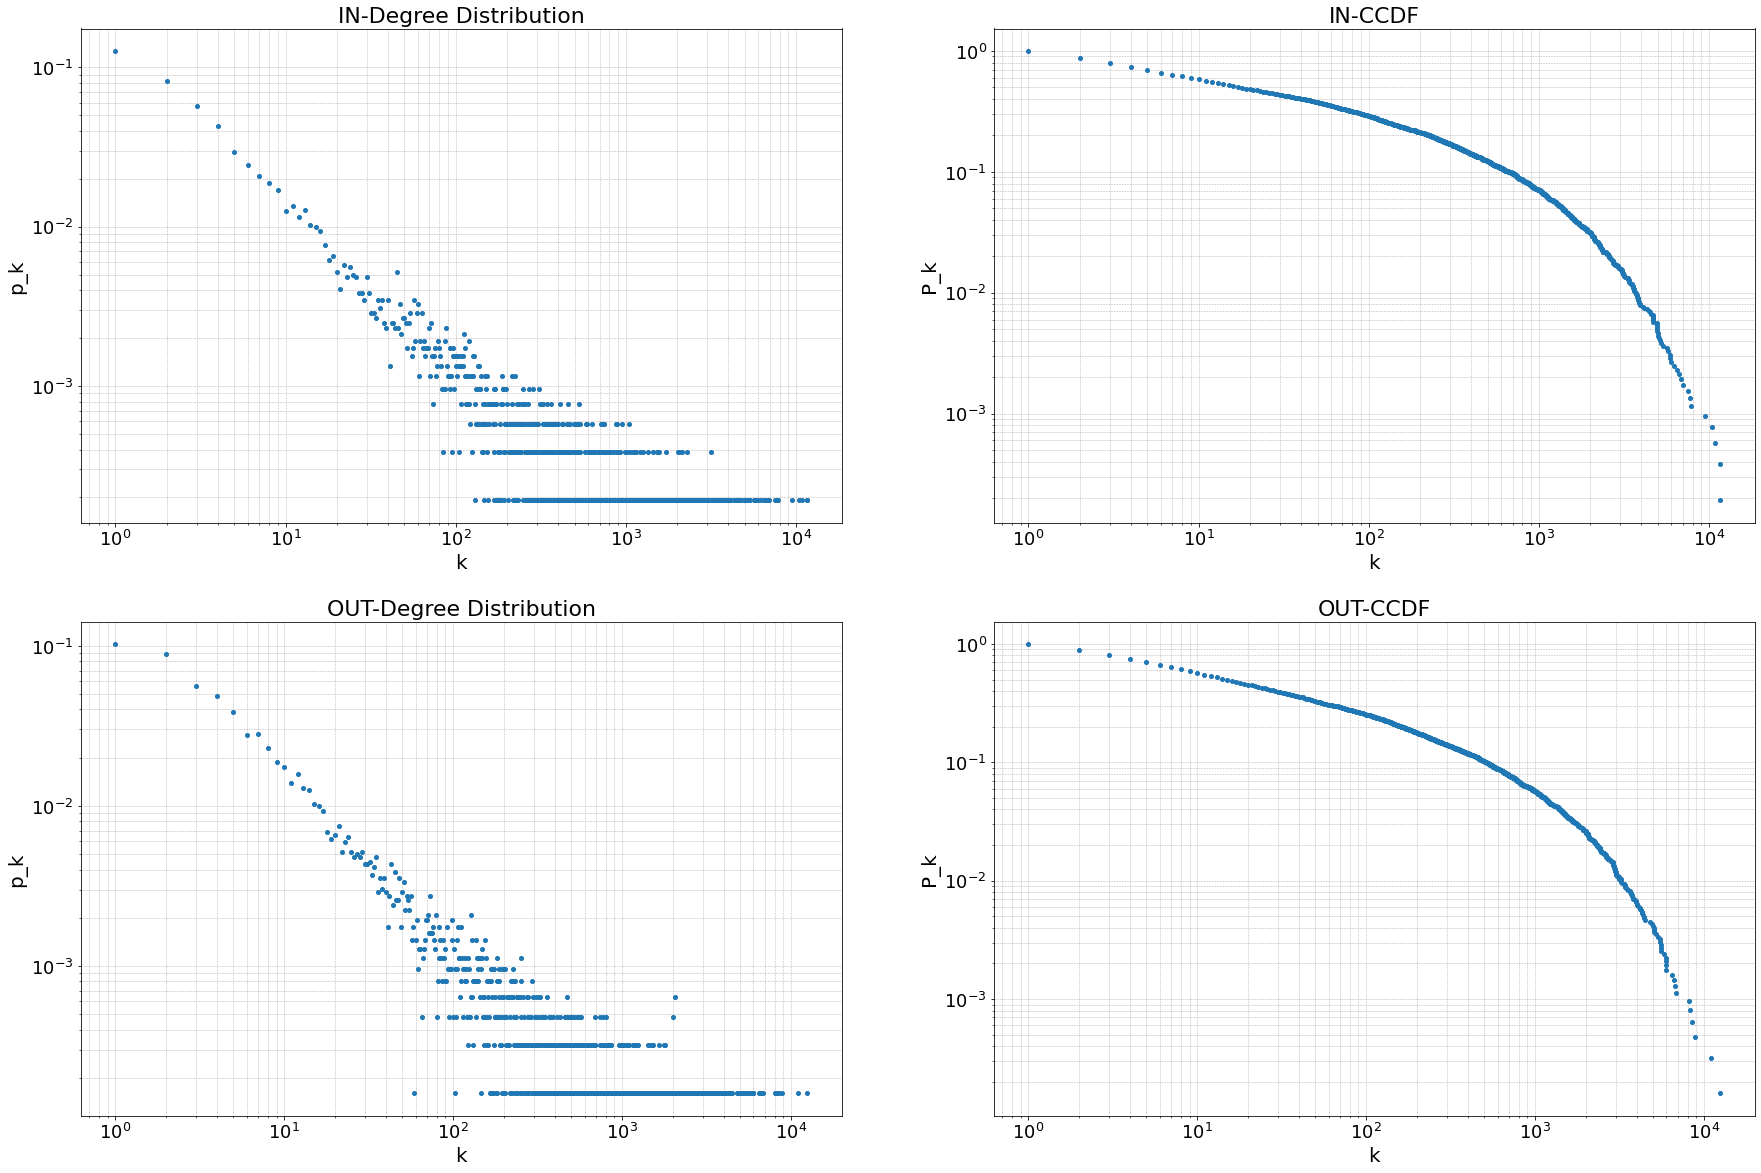

Top 10 for in degree


,Nodes,in degree
1617,UNIVERSITAT DE VALENCIA,11611
5402,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,11540
1842,UNIVERSIDAD DE GRANADA,10809
6537,UNIVERSIDADE DE LISBOA,10424
1976,UNIVERSIDAD COMPLUTENSE DE MADRID,9414
6145,UNIVERSITAT POLITECNICA DE VALENCIA,7854
4363,UNIVERZA V LJUBLJANI,7762
6513,KATHOLIEKE UNIVERSITEIT LEUVEN,7487
6956,UNIVERSIDAD DE SEVILLA,6978
1393,NORGES TEKNISK-NATURVITENSKAPELIGE UNIVERSITET...,6818


Top 10 for out degree


,Nodes,out degree
5402,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,12477
1842,UNIVERSIDAD DE GRANADA,11026
1617,UNIVERSITAT DE VALENCIA,8866
1976,UNIVERSIDAD COMPLUTENSE DE MADRID,8467
4383,UNIVERSITA DEGLI STUDI DI PADOVA,8302
4520,UNIVERSITA DEGLI STUDI DI ROMA LA SAPIENZA,8102
6513,KATHOLIEKE UNIVERSITEIT LEUVEN,6867
4517,UNIVERSIDAD DEL PAIS VASCO/ EUSKAL HERRIKO UNI...,6700
997,UNIVERSITA DEGLI STUDI DI TORINO,6664
2802,UNIVERSIDAD POLITECNICA DE MADRID,6451


In [11]:
scores = ns.degree_disribution(adj_matrix_crs, nodes_df, print_graph=True)
ns.display_top_n(scores, 10, 'in degree')
ns.display_top_n(scores, 10, 'out degree')

### HITS (NetworkX)

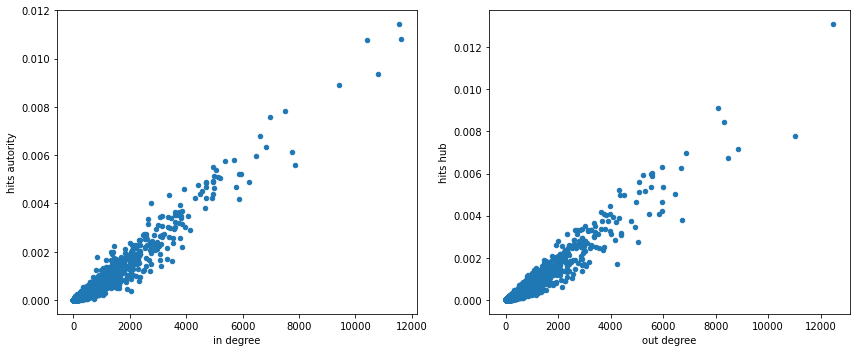

Top 10 for hits hub


,Nodes,hits hub
5402,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,0.013100
4520,UNIVERSITA DEGLI STUDI DI ROMA LA SAPIENZA,0.009089
4383,UNIVERSITA DEGLI STUDI DI PADOVA,0.008444
1842,UNIVERSIDAD DE GRANADA,0.007785
1617,UNIVERSITAT DE VALENCIA,0.007185
6513,KATHOLIEKE UNIVERSITEIT LEUVEN,0.006954
1976,UNIVERSIDAD COMPLUTENSE DE MADRID,0.006739
6537,UNIVERSIDADE DE LISBOA,0.006314
997,UNIVERSITA DEGLI STUDI DI TORINO,0.006247
5365,UNIWERSYTET WARSZAWSKI,0.006037


Top 10 for hits autority


,Nodes,hits autority
5402,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,0.011440
1617,UNIVERSITAT DE VALENCIA,0.010822
6537,UNIVERSIDADE DE LISBOA,0.010794
1842,UNIVERSIDAD DE GRANADA,0.009381
1976,UNIVERSIDAD COMPLUTENSE DE MADRID,0.008920
6513,KATHOLIEKE UNIVERSITEIT LEUVEN,0.007841
6956,UNIVERSIDAD DE SEVILLA,0.007591
5333,UNIVERSITAT DE BARCELONA,0.006804
1393,NORGES TEKNISK-NATURVITENSKAPELIGE UNIVERSITET...,0.006340
4363,UNIVERZA V LJUBLJANI,0.006119


In [12]:
df = ns.hits_alg(adj_matrix_crs, nodes_df, score_df=scores, print_graph=True)
scores = pd.merge(scores, df, on='Nodes')

ns.display_top_n(scores, 10, 'hits hub')
ns.display_top_n(scores, 10, 'hits autority')

### PageRank (NetworkX)

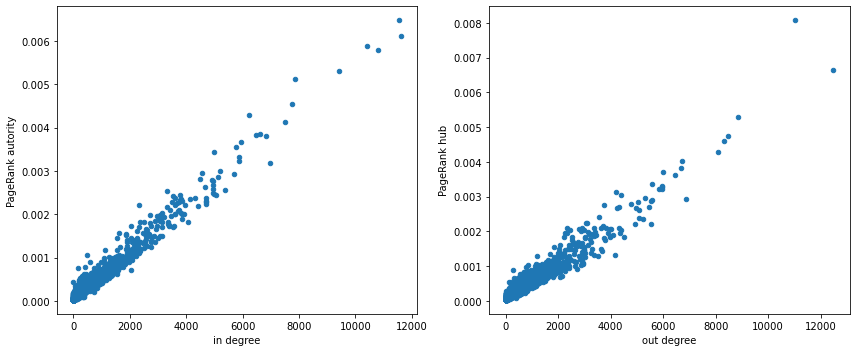

Top 10 for PageRank hub


,Nodes,PageRank hub
1842,UNIVERSIDAD DE GRANADA,0.008073
5402,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,0.006650
1617,UNIVERSITAT DE VALENCIA,0.005288
1976,UNIVERSIDAD COMPLUTENSE DE MADRID,0.004742
4383,UNIVERSITA DEGLI STUDI DI PADOVA,0.004606
4520,UNIVERSITA DEGLI STUDI DI ROMA LA SAPIENZA,0.004285
4517,UNIVERSIDAD DEL PAIS VASCO/ EUSKAL HERRIKO UNI...,0.004039
997,UNIVERSITA DEGLI STUDI DI TORINO,0.003837
4363,UNIVERZA V LJUBLJANI,0.003712
2802,UNIVERSIDAD POLITECNICA DE MADRID,0.003628


Top 10 for PageRank autority


,Nodes,PageRank autority
5402,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,0.006472
1617,UNIVERSITAT DE VALENCIA,0.006109
6537,UNIVERSIDADE DE LISBOA,0.005881
1842,UNIVERSIDAD DE GRANADA,0.005778
1976,UNIVERSIDAD COMPLUTENSE DE MADRID,0.005299
6145,UNIVERSITAT POLITECNICA DE VALENCIA,0.005129
4363,UNIVERZA V LJUBLJANI,0.004541
3578,POLITECNICO DI MILANO,0.004299
6513,KATHOLIEKE UNIVERSITEIT LEUVEN,0.004136
5333,UNIVERSITAT DE BARCELONA,0.003863


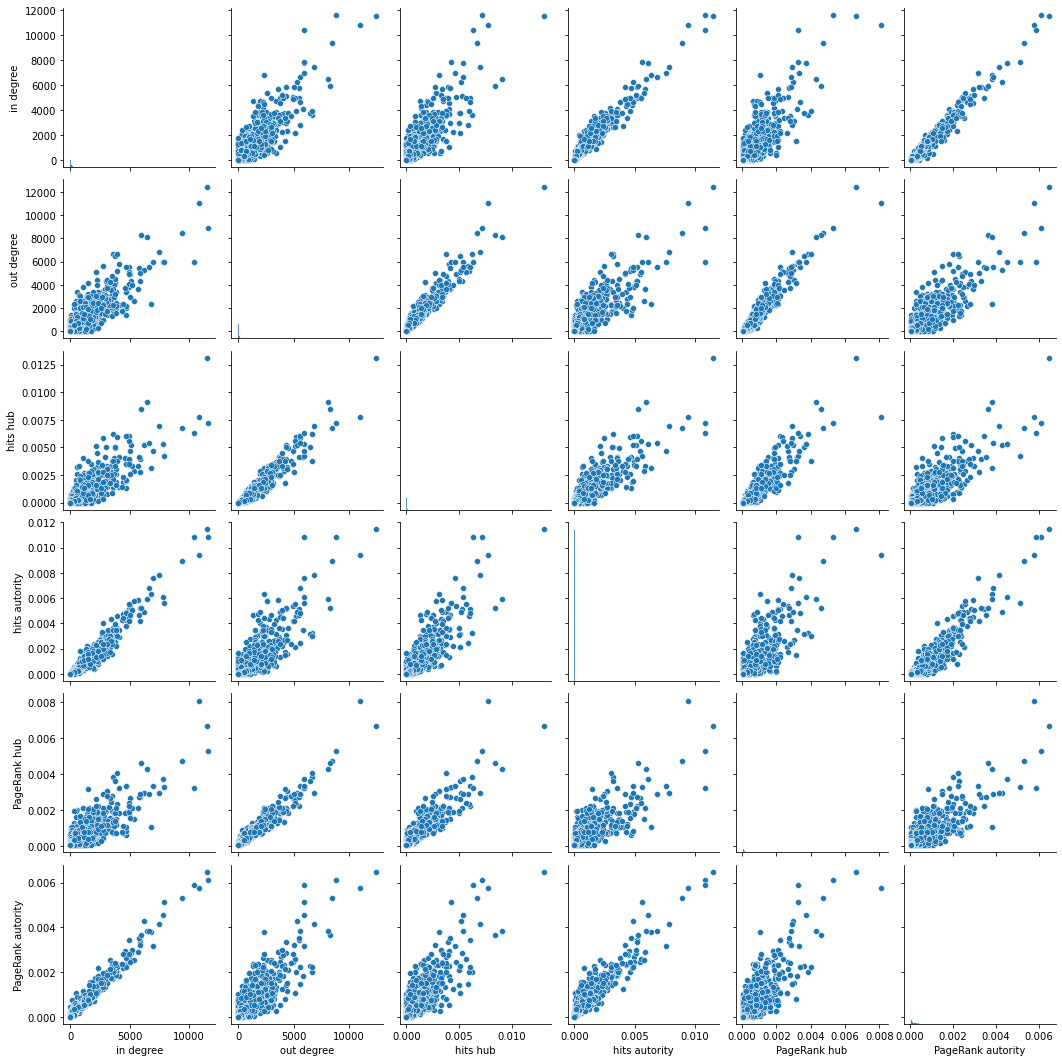

In [13]:
df = ns.pagerank_alg(adj_matrix_crs, nodes_df, score_df=scores, print_graph=True)
scores = pd.merge(scores, df, on='Nodes')

ns.display_top_n(scores, 10, 'PageRank hub')
ns.display_top_n(scores, 10, 'PageRank autority')
# ci vuole troppo a farlo
sns.pairplot(scores[['in degree', 'out degree',  'hits hub',
       'hits autority', 'PageRank hub', 'PageRank autority']])
plt.show()
# from IPython.display import Image
# Image('pairplot_score.png',)

### Assortativity

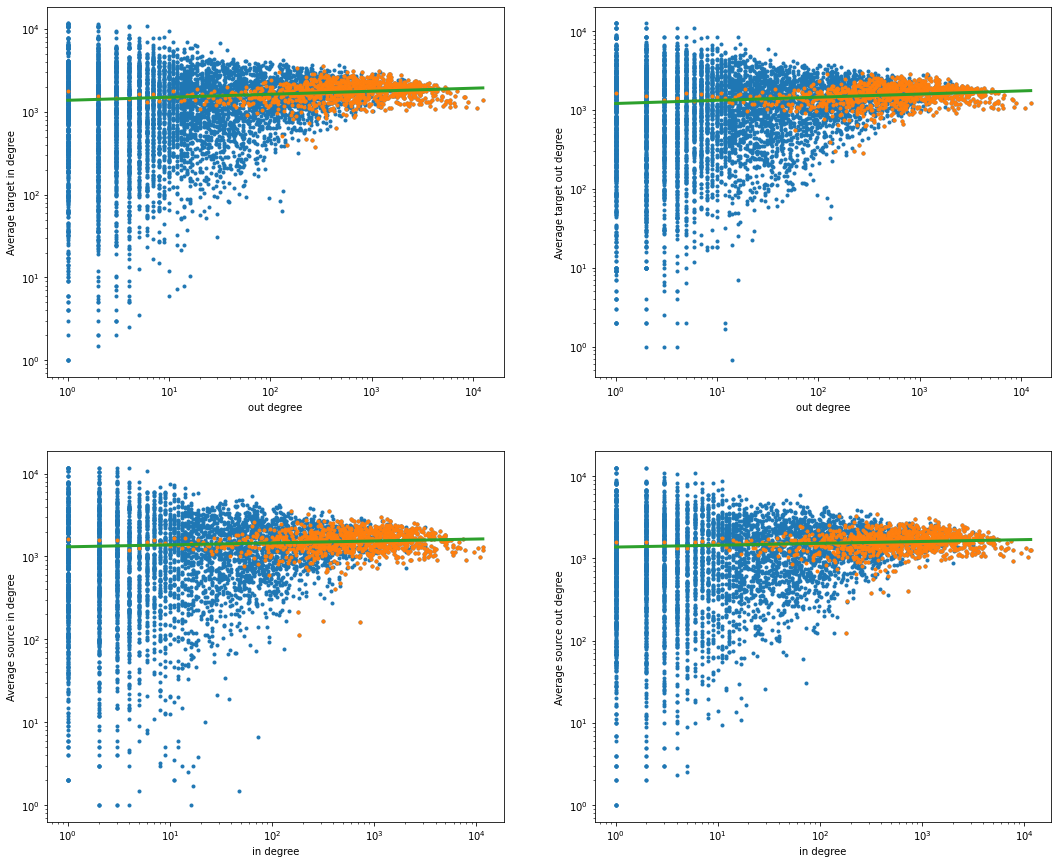

(0.03640225809134686,
 0.039785852725475544,
 0.023439716362907606,
 0.022567719259201067)

In [14]:
edges = mobility_df.copy()
ns.assortativity_calc(edges, adj_matrix_crs, nodes_df, True)

### Number of fields of education per university

Standardising fields

In [15]:
df_w_fields['Field of Education'] = df_w_fields['Field of Education'].str.replace(', not further defined','')
df_w_fields['Field of Education'] = df_w_fields['Field of Education'].str.replace(', inter-disciplinary programmes','')
df_w_fields['Field of Education'] = df_w_fields['Field of Education'].str.replace(', not elsewhere classified','')
df_w_fields['Field of Education'] = df_w_fields['Field of Education'].str.replace(' not elsewhere classified','')
df_w_fields['Field of Education'] = df_w_fields['Field of Education'].str.replace(', not elsewhere classifed','')
df_w_fields['Field of Education'] = df_w_fields['Field of Education'].str.replace('Inter-disciplinary programmes and qualifications involving ','')
df_w_fields['Field of Education'] = df_w_fields['Field of Education'].str.lower()
df_w_fields['Field of Education'] = df_w_fields['Field of Education'].str.strip()

In [16]:
field_dic = {'Education': ['training for pre-school teachers','teacher training without subject specialization','teacher training with subject specialization','education','education science'],
                'Arts and humanities': ['handicrafts','religion and theology','philosophy and ethics','music and performing arts','literature and linguistics','languages','language acquisition','humanities (except languages)','history and archaeology','fine arts','fashion, interior and industrial design','arts', 'arts and humanities', 'audio-visual techniques and media production'],
                'Social sciences, journalism and information': ['sociology and cultural studies','social sciences, journalism and information','social and behavioural sciences','psychology','political sciences and civics','library, information and archival studies','journalism and reporting','journalism and information','economics'],
                'Business, administration and law': ['work skills','wholesale and retail sales','marketing and advertising','management and administration','law','finance, banking and insurance','business, administration and law', 'business and administration', 'accounting and taxation'],
                'Natural sciences, mathematics and statistics': ['statistics','physics','physical sciences','natural sciences, mathematics and statistics','natural environments and wildlife','mathematics and statistics','mathematics','environmental sciences','environment','earth sciences','chemistry', 'biochemistry', 'biological and related sciences', 'biology'],
                'Information and Communication Technologies (ICTs)': ['software and applications development and analysis','information and communication technologies (icts)','database and network design and administration', 'computer use'],
                'Engineering, manufacturing and construction': ['textiles (clothes, footwear and leather)','motor vehicles, ships and aircraft','mining and extraction','mechanics and metal trades','materials (glass, paper, plastic and wood)','manufacturing and processing','food processing','environmental protection technology','electronics and automation','engineering and engineering trades','engineering, manufacturing and construction','electricity and energy','chemical engineering and processes', 'architecture and construction', 'architecture and town planning', 'building and civil engineering'],
                'Agriculture, forestry, fisheries and veterinary': ['veterinary','forestry','fisheries','crop and livestock production', 'agriculture', 'agriculture, forestry, fisheries and veterinary'],
                'Health and welfare': ['welfare','traditional and complementary medicine and therapy','therapy and rehabilitation','pharmacy','nursing and midwifery','medicine','medical diagnostic and treatment technology','hygiene and occupational health services','horticulture','health and welfare','health','dental studies', 'child care and youth services', 'care of the elderly and of disabled adults'],
                'Services': ['travel, tourism and leisure','transport services','sports','social work and counselling','services','security services','secretarial and office work','protection of persons and property','personal services','occupational health and safety','military and defence','hotel, restaurants and catering','hair and beauty services','domestic services','community sanitation']
                }
                
def standard_field(field):
    for f in field_dic.keys():
        if field in field_dic[f]:
            return f

df_w_fields['Field of Education'] = df_w_fields['Field of Education'].apply(standard_field)

Getting the number of fields present in each university

In [17]:
Fields_serie_s = df_w_fields.groupby('Sending Organization')['Field of Education'].unique()
Fields_serie_r = df_w_fields.groupby('Receiving Organization')['Field of Education'].unique()
d = {'sending': Fields_serie_s, 'receiving': Fields_serie_r}
Fields_df = pd.DataFrame(d)

In [18]:
Fields_df = Fields_df.fillna(0) 
#se vi viene in mente un modo migliore per togliere gli NaN e fare l'unione dopo siete i benvenuti
#(non si può fare .fillna([]) purtroppo)
Fields_df['N Fields'] = 0
for i in range(Fields_df.shape[0]):
    s = set() if type(Fields_df['sending'][i])==int else set(Fields_df['sending'][i])
    r = set() if type(Fields_df['receiving'][i])==int else set(Fields_df['receiving'][i])
    Fields_df['N Fields'][i] = len(s | r)
Fields_df['N Fields'].sort_values()

<ipython-input-18-5216e527d0ce>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Fields_df['N Fields'][i] = len(s | r)


UAJY - UNIVERSITAS ATMA JAYA YOGYAKARTA                 1
SCHOOL OF BUSINESS AND MANAGEMENT TECHNOLOGY OF BSU     1
SCHOLAI FREDERICKOU LIMITED                             1
UNIVERSITÉ DE MAHAJANGA                                 1
SCHECHTER INSTITUTE OF JEWISH STUDIES                   1
                                                       ..
NIGDE OMER HALISDEMIR UNIVERSITY                       10
UNIWERSYTET WROCLAWSKI                                 10
UNIWERSYTET WARSZAWSKI                                 10
UNIVERSIDADE NOVA DE LISBOA                            10
MARTIN-LUTHER-UNIVERSITAET HALLE-WITTENBERG            10
Name: N Fields, Length: 7140, dtype: int64

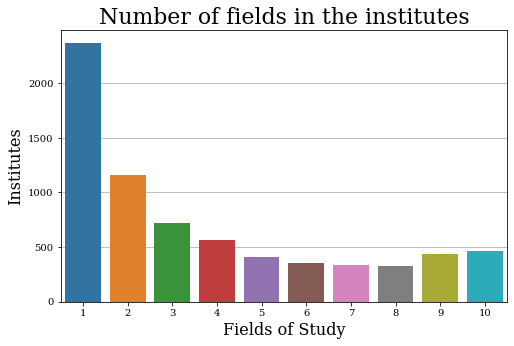

In [47]:
plt.rc('font', family='serif')
plt.rc('axes', axisbelow=True)
fig = plt.figure(figsize=(8,5))
plt.grid(which='major', axis='y')
sns.countplot(x=Fields_df['N Fields'])
plt.xlabel('Fields of Study', size=16)
plt.ylabel('Institutes', size=16)
plt.title('Number of fields in the institutes', size=22)
plt.show()


### Comparing the number of fields to the centrality of universities

In [23]:
Fields_df.drop(['sending', 'receiving'], axis=1, inplace=True)
Fields_df['Nodes'] = Fields_df.index

In [24]:
scores = pd.merge(scores, Fields_df, how='left', on='Nodes')
scores[['Nodes', 'N Fields']].sort_values(by='N Fields', ascending=False) # just to double check

,Nodes,N Fields
1188,TECHNOLOGICAL UNIVERSITY DUBLIN,10
1086,UNIVERSIDADE DE TRAS-OS-MONTES E ALTO DOURO,10
1099,UNIWERSYTET WROCLAWSKI,10
4640,BALIKESIR UNIVERSITY,10
4648,NIGDE OMER HALISDEMIR UNIVERSITY,10
...,...,...
1206,RAVENSBOURNE,1
1203,"EDUCATIONAL INSTITUTION ""GOMEL STATE MEDICAL U...",1
4414,UNIVERSIDADE LURIO,1
4418,NAGAOKA UNIVERSITY OF TECHNOLOGY,1


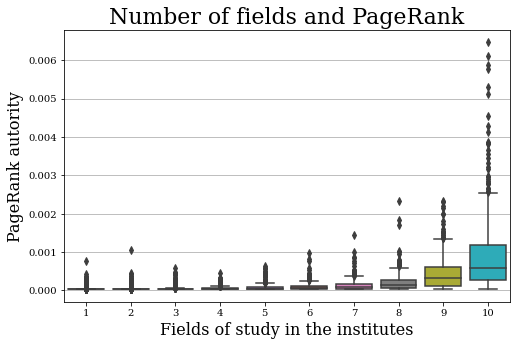

In [45]:
fig = plt.figure(figsize=(8,5))
plt.grid(which='major', axis='y')
sns.boxplot(x=scores['N Fields'], y=scores['PageRank autority'])
plt.xlabel('Fields of study in the institutes', size=16)
plt.ylabel('PageRank autority', size=16)
plt.title('Number of fields and PageRank', size=22)
plt.show()

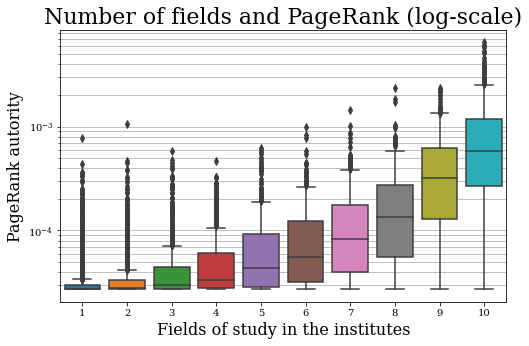

In [46]:
fig = plt.figure(figsize=(8,5))
plt.grid(which='both', axis='y')
plt.yscale('log')
sns.boxplot(x=scores['N Fields'], y=scores['PageRank autority'])
plt.xlabel('Fields of study in the institutes', size=16)
plt.ylabel('PageRank autority', size=16)
plt.title('Number of fields and PageRank (log-scale)', size=22)
plt.show()

There are two big outliers with 1 and 2 fields:

In [42]:
for i in scores[(scores['N Fields']<3) & (scores['PageRank autority']>0.0007)]['Nodes']:
    print(i)

CONSERVATOIRE NATIONAL SUPÉRIEUR DE MUSIQUE ET DE DANSE DE PARIS
TAIDEYLIOPISTO


The centrality of a university seems to be (approximately) exponential in the number of fields of education present in the university

### Robustness

We want to see how many nodes remain in the giant component, while we remove one node after the other. We compare two possibilities: an attack in which we remove the most important nodes first, and random node removal (taking averages).

In [48]:
#attack: removing hubs first
nodes_byhub = scores.sort_values('PageRank hub', ascending=False)['NodeID']
indices = list(nodes_byhub)
uni_df = mobility_df.copy()
GC_frac_a = [1]
for node in indices:
    uni_df = uni_df.loc[(uni_df['sourceID'] != node) & (uni_df['targetID'] != node)]
    temp_serie = uni_df.groupby(['sourceID', 'targetID']).sum()
    row = np.array(temp_serie.index.get_level_values(1).tolist())
    col = np.array(temp_serie.index.get_level_values(0).tolist())
    val = temp_serie.values
    temp_adj = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))
    GC_frac_a.append(ns.fraction_in_giant(temp_adj))


In [50]:
#random node removal
import random
#70 by 70, with average over 10 trials each time
intervals = list(range(70, len(nodes_byhub+1), 70))
uni_df = mobility_df.copy()
GC_frac_r = [1]
for i in intervals:
    i_GC_frac = []
    for j in range(10):
        removed = random.sample(indices, i)
        temp_df = uni_df.loc[~(uni_df['sourceID'].isin(removed) | (uni_df['targetID'].isin(removed)))]
        temp_serie = temp_df.groupby(['sourceID', 'targetID']).sum()
        row = np.array(temp_serie.index.get_level_values(1).tolist())
        col = np.array(temp_serie.index.get_level_values(0).tolist())
        val = temp_serie.values
        temp_adj = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))
        i_GC_frac.append(ns.fraction_in_giant(temp_adj))
    GC_frac_r.append(sum(i_GC_frac)/10)

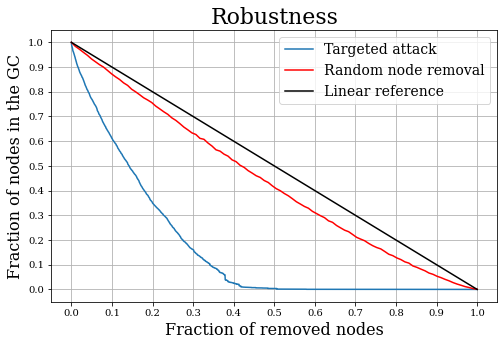

In [54]:
fig, ax = plt.subplots(figsize=(8,5))
ax.grid(which='major')
ax.plot([i/len(nodes_byhub) for i in range(len(nodes_byhub)+1)], GC_frac_a, label='Targeted attack')
ax.plot([0]+[i/(len(intervals)*70) for i in intervals], GC_frac_r, 'r', label='Random node removal')
ax.plot([0,1], [1,0], 'k', label='Linear reference')
ax.set_xlabel('Fraction of removed nodes', size=16)
ax.set_ylabel('Fraction of nodes in the GC', size=16)
ax.set_yticks(np.arange(0,1.01,0.1))
ax.set_xticks(np.arange(0,1.01,0.1))
#ax.yaxis.set_minor_locator(AutoMinorLocator(2))
#ax.grid(which='minor', axis='y')
ax.set_title('Robustness', size=22)
plt.legend(fontsize=14)
plt.show()